#Import Required Packages + Tools

In [1]:
# English wordnet
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn_en

# Russian wordnet
!pip install ruwordnet
!ruwordnet download
from ruwordnet import RuWordNet
wn_ru = RuWordNet()

# spaCy tools (stop word removal, pos-tagging, lemmatizer)
import spacy

!python -m spacy download en_core_web_lg
model_en = spacy.load('en_core_web_lg')
stopwords_en = model_en.Defaults.stop_words

!python -m spacy download ru_core_news_lg
model_ru = spacy.load('ru_core_news_lg')
stopwords_ru = model_ru.Defaults.stop_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


downloading a ruwordnet model from https://github.com/avidale/python-ruwordnet/releases/download/0.0.4/ruwordnet-2021.db
2023-12-16 19:40:40.585709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 19:40:40.585781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 19:40:40.587496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 19:40:41.904687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 996.7 kB/s eta 0:00:00
✔ Download and installation successf

# Dataset Generation + Pre-Processing

## Import and Format English Dataset

In [2]:
from nltk.corpus import semcor
nltk.download('semcor')

words_en = ["time", "world", "day", "man", "woman", "thing", "life", "country", "work", "place"]
data_en_X = []
data_en_y = []

tagged_sents = semcor.tagged_sents(tag='sem')
sents = semcor.sents()
for i in range(len(sents)):
  tagged_sent = tagged_sents[i]
  sent = sents[i]
  for word in tagged_sent:
    if isinstance(word, nltk.tree.Tree) and isinstance(word.label(), nltk.corpus.reader.wordnet.Lemma):
      if word.label().name() in words_en:
        data_en_X.append([sent, words_en.index(word.label().name())])
        data_en_y.append(word.label().key())

[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!


## Import and Format Russian Dataset

In [3]:
import csv
nltk.download('punkt')

file = open("opencorpora-rwn.tsv")
rawdata_ru = csv.reader(file, delimiter="\t")

words_ru = ["время", "дело", "день", "мир", "конец", "вопрос", "голова", "страна", "работа", "место"]
data_ru_X = []
data_ru_y = []

for line in rawdata_ru:
  if line[5].split(' ')[0] in words_ru:
    data_ru_X.append([nltk.tokenize.word_tokenize(line[2]), words_ru.index(line[5].split(' ')[0])])
    data_ru_y.append(line[6])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Russian Case Tagger

In [4]:
def get_case_tag(token):
  label_list = str(token.morph).split(sep="|")
  case_tag = "DNE"
  for label in label_list:
    if label.split(sep='=')[0] == "Case":
      case_tag = label.split(sep='=')[1]
  return case_tag

## Preprocess Both Datasets

In [5]:
"""
v1: No preprocessing
v2: Remove stopwords
v3: Lemmatization
v4: POS-tagging
v5: Remove stopwords + lemmatization
v6: Remove stopwords + POS-tagging
v7: Lemmatization + POS-tagging
v8: Remove stopwords + lemmatization + POS-tagging
v9: Case tagging only
v10: Case tagging + remove stopwords
v11: Case tagging + lemmatization
v12: Case tagging + lemmatization + remove stopwords
"""
labels_en = ["None", "RS", "Lemma", "POS", "RS + Lemma", "RS + POS", "Lemma + POS", "RS + Lemma + POS"]
labels_ru = ["None", "RS", "Lemma", "POS", "RS + Lemma", "RS + POS", "Lemma + POS", "RS + Lemma + POS", "Case", "RS + Case", "Lemma + Case", "RS + Lemma + Case"]

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
import string
punctuation = [*string.punctuation, "``", "''", '«', '»']

def vectorize(dataset):
  vectorizer = CountVectorizer()
  new_dataset = vectorizer.fit_transform([' '.join(row[0]) for row in dataset])
  new_dataset = sparse.hstack((sparse.csr_matrix([[row[1]] for row in dataset]), new_dataset))
  return new_dataset

def create_v1(dataset):
  new_dataset = []
  for sent in dataset:
    new_dataset.append([list(map(lambda x : x.lower(), list(filter(lambda x: x.lower() not in punctuation, sent[0])))), sent[1]])
  return new_dataset

def create_v2(dataset, stopwords):
  new_dataset = []
  for sent in dataset:
    new_dataset.append([list(map(lambda x : x.lower(), list(filter(lambda x: x.lower() not in stopwords and x.lower() not in punctuation, sent[0])))), sent[1]])
  return new_dataset

def create_v3(dataset, model):
  new_dataset = []
  for sent in dataset:
    lemmatized_sent = []
    doc = model(' '.join(sent[0]))
    for token in doc:
      if str(token) not in punctuation:
        lemmatized_sent.append(token.lemma_)
    new_dataset.append([lemmatized_sent, sent[1]])
  return new_dataset

def create_v4(dataset, model):
  new_dataset = []
  for sent in dataset:
    doc = model(' '.join(sent[0]))
    tagged_sent = []
    for token in doc:
      if str(token) not in punctuation:
        tagged_sent.append(str(token).lower() + token.pos_)
    new_dataset.append([tagged_sent, sent[1]])
  return new_dataset

def create_v5(dataset, model, stopwords):
  new_dataset = []
  for sent in dataset:
    lemmatized_sent = []
    doc = model(' '.join(sent[0]))
    for token in doc:
      if str(token).lower() not in stopwords and str(token) not in punctuation:
        lemmatized_sent.append(token.lemma_)
    new_dataset.append([lemmatized_sent, sent[1]])
  return new_dataset

def create_v6(dataset, model, stopwords):
  new_dataset = []
  for sent in dataset:
    doc = model(' '.join(sent[0]))
    tagged_sent = []
    for token in doc:
      if str(token).lower() not in stopwords and str(token) not in punctuation:
        tagged_sent.append(str(token).lower() + token.pos_)
    new_dataset.append([tagged_sent, sent[1]])
  return new_dataset

def create_v7(dataset, model):
  new_dataset = []
  for sent in dataset:
    processed_sent = []
    doc = model(' '.join(sent[0]))
    for token in doc:
      if str(token) not in punctuation:
        processed_sent.append(token.lemma_ + token.pos_)
    new_dataset.append([processed_sent, sent[1]])
  return new_dataset

def create_v8(dataset, model, stopwords):
  new_dataset = []
  for sent in dataset:
    processed_sent = []
    doc = model(' '.join(sent[0]))
    for token in doc:
      if str(token).lower() not in stopwords and str(token) not in punctuation:
        processed_sent.append(token.lemma_ + token.pos_)
    new_dataset.append([processed_sent, sent[1]])
  return new_dataset

def create_v9(dataset, model):
  new_dataset = []
  for sent in dataset:
    doc = model(' '.join(sent[0]))
    tagged_sent = []
    for token in doc:
      if str(token) not in punctuation:
        tagged_sent.append(str(token).lower() + get_case_tag(token))
    new_dataset.append([tagged_sent, sent[1]])
  return new_dataset

def create_v10(dataset, model, stopwords):
  new_dataset = []
  for sent in dataset:
    doc = model(' '.join(sent[0]))
    tagged_sent = []
    for token in doc:
      if str(token).lower() not in stopwords and str(token) not in punctuation:
        tagged_sent.append(str(token).lower() + get_case_tag(token))
    new_dataset.append([tagged_sent, sent[1]])
  return new_dataset

def create_v11(dataset, model):
  new_dataset = []
  for sent in dataset:
    processed_sent = []
    doc = model(' '.join(sent[0]))
    for token in doc:
      if str(token) not in punctuation:
        processed_sent.append(token.lemma_ + get_case_tag(token))
    new_dataset.append([processed_sent, sent[1]])
  return new_dataset

def create_v12(dataset, model, stopwords):
  new_dataset = []
  for sent in dataset:
    processed_sent = []
    doc = model(' '.join(sent[0]))
    for token in doc:
      if str(token).lower() not in stopwords and str(token) not in punctuation:
        processed_sent.append(token.lemma_ + get_case_tag(token))
    new_dataset.append([processed_sent, sent[1]])
  return new_dataset

preprocessed_data_en, preprocessed_data_ru = [], []

# Prepare v1 of the datasets
preprocessed_data_en.append(vectorize(create_v1(data_en_X)))
preprocessed_data_ru.append(vectorize(create_v1(data_ru_X)))

# Prepare v2 of the datasets
preprocessed_data_en.append(vectorize(create_v2(data_en_X, stopwords_en)))
preprocessed_data_ru.append(vectorize(create_v2(data_ru_X, stopwords_ru)))

# Prepare v3 of the datasets
preprocessed_data_en.append(vectorize(create_v3(data_en_X, model_en)))
preprocessed_data_ru.append(vectorize(create_v3(data_ru_X, model_ru)))

# Prepare v4 of the datasets
preprocessed_data_en.append(vectorize(create_v4(data_en_X, model_en)))
preprocessed_data_ru.append(vectorize(create_v4(data_ru_X, model_ru)))

# Prepare v5 of the datasets
preprocessed_data_en.append(vectorize(create_v5(data_en_X, model_en, stopwords_en)))
preprocessed_data_ru.append(vectorize(create_v5(data_ru_X, model_ru, stopwords_ru)))

# Prepare v6 of the datasets
preprocessed_data_en.append(vectorize(create_v6(data_en_X, model_en, stopwords_en)))
preprocessed_data_ru.append(vectorize(create_v6(data_ru_X, model_ru, stopwords_ru)))

# Prepare v7 of the datasets
preprocessed_data_en.append(vectorize(create_v7(data_en_X, model_en)))
preprocessed_data_ru.append(vectorize(create_v7(data_ru_X, model_ru)))

# Prepare v8 of the datasets
preprocessed_data_en.append(vectorize(create_v8(data_en_X, model_en, stopwords_en)))
preprocessed_data_ru.append(vectorize(create_v8(data_ru_X, model_ru, stopwords_ru)))

# Prepare v9 of the Russian dataset
preprocessed_data_ru.append(vectorize(create_v9(data_ru_X, model_ru)))

# Prepare v10 of the Russian dataset
preprocessed_data_ru.append(vectorize(create_v10(data_ru_X, model_ru, stopwords_ru)))

# Prepare v11 of the Russian dataset
preprocessed_data_ru.append(vectorize(create_v11(data_ru_X, model_ru)))

# Prepare v12 of the Russian dataset
preprocessed_data_ru.append(vectorize(create_v12(data_ru_X, model_ru, stopwords_ru)))

## Train-Test-Validate Split

In [6]:
from sklearn.model_selection import train_test_split

X_train_en, X_train_ru, y_train_en, y_train_ru = [], [], [], []
X_test_en, X_test_ru, y_test_en, y_test_ru = [], [], [], []
X_valid_en, X_valid_ru, y_valid_en, y_valid_ru = [], [], [], []

for dataset in preprocessed_data_en:
  X_train, X_test, y_train, y_test = train_test_split(dataset, data_en_y, test_size=0.30, random_state=10)
  X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=10)
  X_train_en.append(X_train)
  X_test_en.append(X_test)
  X_valid_en.append(X_valid)
  y_train_en.append(y_train)
  y_test_en.append(y_test)
  y_valid_en.append(y_valid)

for dataset in preprocessed_data_ru:
  X_train, X_test, y_train, y_test = train_test_split(dataset, data_ru_y, test_size=0.30, random_state=10)
  X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=10)
  X_train_ru.append(X_train)
  X_test_ru.append(X_test)
  X_valid_ru.append(X_valid)
  y_train_ru.append(y_train)
  y_test_ru.append(y_test)
  y_valid_ru.append(y_valid)

# Train Models

In [7]:
from sklearn.naive_bayes import ComplementNB

resultsNB_en = []
for i in range(len(X_train_en)):
  y_pred = ComplementNB().fit(X_train_en[i].toarray(), y_train_en[i]).predict(X_test_en[i].toarray())
  print("Accuracy of " + labels_en[i] + "(English): " + str((y_test_en[i] == y_pred).sum() / X_test_en[i].shape[0]))
  resultsNB_en.append((y_test_en[i] == y_pred).sum() / X_test_en[i].shape[0])

resultsNB_ru = []
for i in range(len(X_train_ru)):
  y_pred = ComplementNB().fit(X_train_ru[i].toarray(), y_train_ru[i]).predict(X_test_ru[i].toarray())
  print("Accuracy of " + labels_ru[i] + "(Russian): " + str((y_test_ru[i] == y_pred).sum() / X_test_ru[i].shape[0]))
  resultsNB_ru.append((y_test_ru[i] == y_pred).sum() / X_test_ru[i].shape[0])

Accuracy of None(English): 0.34773218142548595
Accuracy of RS(English): 0.3282937365010799
Accuracy of Lemma(English): 0.3369330453563715
Accuracy of POS(English): 0.3563714902807775
Accuracy of RS + Lemma(English): 0.3045356371490281
Accuracy of RS + POS(English): 0.3326133909287257
Accuracy of Lemma + POS(English): 0.3412526997840173
Accuracy of RS + Lemma + POS(English): 0.31965442764578833
Accuracy of None(Russian): 0.5782312925170068
Accuracy of RS(Russian): 0.5714285714285714
Accuracy of Lemma(Russian): 0.5238095238095238
Accuracy of POS(Russian): 0.5714285714285714
Accuracy of RS + Lemma(Russian): 0.5170068027210885
Accuracy of RS + POS(Russian): 0.5578231292517006
Accuracy of Lemma + POS(Russian): 0.5238095238095238
Accuracy of RS + Lemma + POS(Russian): 0.5102040816326531
Accuracy of Case(Russian): 0.5714285714285714
Accuracy of RS + Case(Russian): 0.5578231292517006
Accuracy of Lemma + Case(Russian): 0.5374149659863946
Accuracy of RS + Lemma + Case(Russian): 0.54421768707483


In [9]:
from sklearn import svm

resultsSVM_en = []
for i in range(len(X_train_en)):
  y_pred = svm.SVC().fit(X_train_en[i].toarray(), y_train_en[i]).predict(X_test_en[i].toarray())
  print("Accuracy of " + labels_en[i] + "(English): " + str((y_test_en[i] == y_pred).sum() / X_test_en[i].shape[0]))
  resultsSVM_en.append((y_test_en[i] == y_pred).sum() / X_test_en[i].shape[0])

resultsSVM_ru = []
for i in range(len(X_train_ru)):
  y_pred = svm.SVC().fit(X_train_ru[i].toarray(), y_train_ru[i]).predict(X_test_ru[i].toarray())
  print("Accuracy of " + labels_ru[i] + "(Russian): " + str((y_test_ru[i] == y_pred).sum() / X_test_ru[i].shape[0]))
  resultsSVM_ru.append((y_test_ru[i] == y_pred).sum() / X_test_ru[i].shape[0])

Accuracy of None(English): 0.47516198704103674
Accuracy of RS(English): 0.4708423326133909
Accuracy of Lemma(English): 0.4557235421166307
Accuracy of POS(English): 0.4708423326133909
Accuracy of RS + Lemma(English): 0.45788336933045354
Accuracy of RS + POS(English): 0.4773218142548596
Accuracy of Lemma + POS(English): 0.4708423326133909
Accuracy of RS + Lemma + POS(English): 0.48596112311015116
Accuracy of None(Russian): 0.6394557823129252
Accuracy of RS(Russian): 0.6462585034013606
Accuracy of Lemma(Russian): 0.6258503401360545
Accuracy of POS(Russian): 0.6326530612244898
Accuracy of RS + Lemma(Russian): 0.6462585034013606
Accuracy of RS + POS(Russian): 0.6598639455782312
Accuracy of Lemma + POS(Russian): 0.6122448979591837
Accuracy of RS + Lemma + POS(Russian): 0.6530612244897959
Accuracy of Case(Russian): 0.6122448979591837
Accuracy of RS + Case(Russian): 0.6462585034013606
Accuracy of Lemma + Case(Russian): 0.6190476190476191
Accuracy of RS + Lemma + Case(Russian): 0.64625850340136

In [19]:
from sklearn.neural_network import MLPClassifier

resultsMLP_en = []
for i in range(len(X_train_en)):
  y_pred = MLPClassifier(random_state=1, max_iter=300).fit(X_train_en[i].toarray(), y_train_en[i]).predict(X_test_en[i].toarray())
  print("Accuracy of " + labels_en[i] + "(English): " + str((y_test_en[i] == y_pred).sum() / X_test_en[i].shape[0]))
  resultsMLP_en.append((y_test_en[i] == y_pred).sum() / X_test_en[i].shape[0])

resultsMLP_ru = []
for i in range(len(X_train_ru)):
  y_pred = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,100,)).fit(X_train_ru[i].toarray(), y_train_ru[i]).predict(X_test_ru[i].toarray())
  print("Accuracy of " + labels_ru[i] + "(Russian): " + str((y_test_ru[i] == y_pred).sum() / X_test_ru[i].shape[0]))
  resultsMLP_ru.append((y_test_ru[i] == y_pred).sum() / X_test_ru[i].shape[0])

Accuracy of None(English): 0.42116630669546434
Accuracy of RS(English): 0.39740820734341253
Accuracy of Lemma(English): 0.4427645788336933
Accuracy of POS(English): 0.4298056155507559


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of RS + Lemma(English): 0.42116630669546434
Accuracy of RS + POS(English): 0.42764578833693306
Accuracy of Lemma + POS(English): 0.4319654427645788


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of RS + Lemma + POS(English): 0.38876889848812096
Accuracy of None(Russian): 0.5306122448979592
Accuracy of RS(Russian): 0.5782312925170068
Accuracy of Lemma(Russian): 0.6326530612244898
Accuracy of POS(Russian): 0.564625850340136
Accuracy of RS + Lemma(Russian): 0.5986394557823129
Accuracy of RS + POS(Russian): 0.5306122448979592
Accuracy of Lemma + POS(Russian): 0.6054421768707483
Accuracy of RS + Lemma + POS(Russian): 0.5714285714285714
Accuracy of Case(Russian): 0.54421768707483
Accuracy of RS + Case(Russian): 0.4965986394557823
Accuracy of Lemma + Case(Russian): 0.5238095238095238
Accuracy of RS + Lemma + Case(Russian): 0.5102040816326531


# Visualize Results

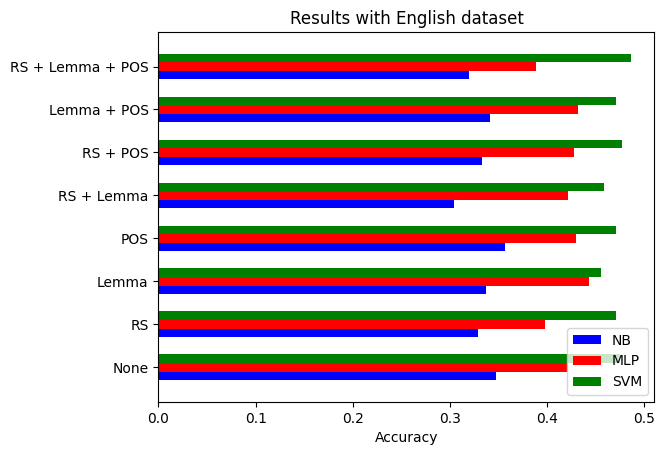

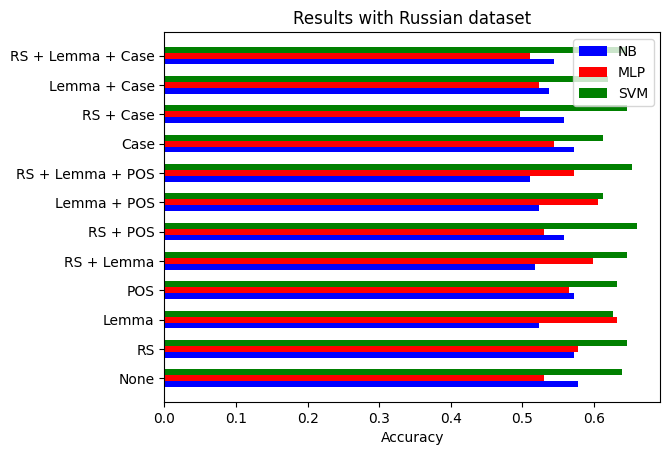

In [20]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.DataFrame(dict(graph=labels_en, a=resultsNB_en, b=resultsMLP_en, c=resultsSVM_en))
ind = np.arange(len(df))
width = 0.2
fig, ax = plt.subplots()
ax.barh(ind, df.a, width, color='blue', label='NB')
ax.barh(ind + width, df.b, width, color='red', label='MLP')
ax.barh(ind + 2*width, df.c, width, color='green', label='SVM')
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.title("Results with English dataset")
plt.xlabel("Accuracy")
plt.show()

df = pandas.DataFrame(dict(graph=labels_ru, a=resultsNB_ru, b=resultsMLP_ru, c=resultsSVM_ru))
ind = np.arange(len(df))
width = 0.2
fig, ax = plt.subplots()
ax.barh(ind, df.a, width, color='blue', label='NB')
ax.barh(ind + width, df.b, width, color='red', label='MLP')
ax.barh(ind + 2*width, df.c, width, color='green', label='SVM')
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.title("Results with Russian dataset")
plt.xlabel("Accuracy")
plt.show()